In [7]:
import nibabel as nib
import SimpleITK as sitk
import radiomics
from radiomics import featureextractor, getTestCase
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob
from tqdm import tqdm
import six
import multiprocessing as mp
import seaborn as sns
data_path = Path("/media/7tb_encrypted/od_chall/dataset/challenge_data")
crops_path = data_path / "train/crops"
this_path = Path().resolve()


In [10]:
# radiomics
radiomics_df = pd.read_csv(this_path.parent / "test_radiomics_features.csv")
# radiomics_df.label = radiomics_df.label.replace({np.NaN: 'normal',
#                                         '_sphere_outlier_mean_std_inpaint': 'sphere_mean',
#                                         '_sphere_outlier_water': 'sphere_water',
#                                         '_warp_outlier': 'warp'})
# radiomics_df = radiomics_df.drop(columns=['label'])
# radiomics_df.to_csv(this_path.parent / "test_radiomics_features.csv", index=False)

In [11]:
radiomics_df

,sample_id,img_name,label_name,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,...,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idm,original_glcm_Idmn,original_glcm_Id,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumEntropy,original_glcm_SumSquares
0,sample_0538,sample_0538_crop.nii.gz,sample_0538_crop_label.nii.gz,0.662166,0.515845,34.574678,67.025366,57.630287,77.420927,72.520687,...,-0.282383,0.968675,0.361960,0.995107,0.432224,0.956599,0.345018,0.016822,6.082047,118.645095
1,sample_0824,sample_0824_crop.nii.gz,sample_0824_crop_label.nii.gz,0.713804,0.481009,28.408944,59.061107,55.226805,69.588074,59.709714,...,-0.187228,0.899188,0.318879,0.994745,0.395723,0.956273,0.311680,0.020139,5.687001,86.245620
2,sample_0813,sample_0813_crop.nii.gz,sample_0813_crop_label.nii.gz,0.808714,0.548193,31.682402,57.794279,57.054798,71.309186,67.383232,...,-0.287994,0.959700,0.453871,0.997300,0.507214,0.970773,0.382399,0.047657,5.542407,97.172364
3,sample_0693,sample_0693_crop.nii.gz,sample_0693_crop_label.nii.gz,0.627657,0.441981,31.405705,71.056717,59.135438,84.594622,67.935631,...,-0.266618,0.957054,0.374544,0.996463,0.444329,0.962294,0.359642,0.021040,5.785704,74.368082
4,sample_0615,sample_0615_crop.nii.gz,sample_0615_crop_label.nii.gz,0.617034,0.425582,31.144790,73.181664,54.893078,83.919604,72.154348,...,-0.255859,0.960303,0.325760,0.995275,0.402209,0.956624,0.321577,0.013146,6.154365,127.160220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,sample_0277,sample_0277_crop.nii.gz,sample_0277_crop_label.nii.gz,0.664336,0.470815,34.100837,72.429316,72.506896,85.154272,78.768649,...,-0.285901,0.966189,0.404039,0.996781,0.466358,0.966307,0.369345,0.024434,5.889753,90.072681
543,sample_0566,sample_0566_crop.nii.gz,sample_0566_crop_label.nii.gz,0.681323,0.488567,39.535888,80.922147,72.763315,94.997368,91.654242,...,-0.273251,0.962416,0.364001,0.998311,0.435267,0.973881,0.353617,0.018617,5.909346,102.401652
544,sample_0458,sample_0458_crop.nii.gz,sample_0458_crop_label.nii.gz,0.782532,0.477250,38.420056,80.503035,89.568410,97.943861,94.469572,...,-0.326241,0.972374,0.464203,0.997690,0.518489,0.970546,0.410684,0.033509,5.592870,58.047228
545,sample_0765,sample_0765_crop.nii.gz,sample_0765_crop_label.nii.gz,0.726799,0.436853,36.150779,82.752753,77.189701,91.919802,94.595190,...,-0.308118,0.973414,0.424480,0.996626,0.484080,0.965687,0.385027,0.024460,5.918664,101.575104


In [6]:
metadata = radiomics_df.loc[:, ['sample_id', 'img_name', 'label_name', 'label']]
metadata.to_csv("/media/7tb_encrypted/od_chall/dataset/challenge_data/train/metadata.csv", index=False)

In [5]:
metadata.label.value_counts()

label
sphere_water    546
sphere_mean     546
normal          546
warp            546
Name: count, dtype: int64

In [3]:
radiomics_df.label.value_counts()

label
sphere_water    546
sphere_mean     546
normal          546
warp            546
Name: count, dtype: int64

In [2]:
train_ids = glob.glob(str(crops_path / "*_crop.nii.gz"))
train_ids = [Path(x).name.split('_crop')[0] for x in train_ids]
len(train_ids)
# 'sample_0575_crop_sphere_outlier_mean_std_inpaint.nii.gz'

546

In [ ]:
# radiomics params
params = this_path / 'Params.yaml'

# file types
results = []
file_types = {'normal': '',
              'sphere_mean': '_sphere_outlier_mean_std_inpaint',
              'sphere_water': '_sphere_outlier_water',
              'warp': '_warp_outlier'}
# ['', '_sphere_outlier_mean_std_inpaint', '_sphere_outlier_water', '_warp_outlier']
for sample in tqdm(train_ids, total=len(train_ids)):
    for label, file_type in file_types.items():
        img_path = crops_path / f"{sample}_crop{file_type}.nii.gz"
        label_path = crops_path / f"{sample}_crop_label{file_type}.nii.gz"
        assert img_path.exists() and label_path.exists(), f"{img_path} or {label_path} does not exist"
        img = sitk.ReadImage(img_path)
        mask = sitk.ReadImage(label_path)

        extractor = featureextractor.RadiomicsFeatureExtractor(str(params))
        result = extractor.execute(img, mask)
        features = {}
        features['sample_id'] = sample
        features['img_name'] = img_path.name
        features['label_name'] = label_path.name
        features['label'] = label
        for key, value in six.iteritems(result):
            if key.startswith(('original_shape', 'original_firstorder', 'original_glcm')):
                features[key] = value
        results.append(features)
    # break
# pd.DataFrame(features, index=None)
df = pd.DataFrame(results)
df.to_csv('radiomics_features.csv', index=False)


In [ ]:
import pandas as pd
import SimpleITK as sitk
import six
from pathlib import Path
from tqdm import tqdm
import multiprocessing
from radiomics import featureextractor  # Assuming this is the correct import for your feature extractor

# Assuming this_path and crops_path are defined somewhere above this code
params = this_path / 'Params.yaml'

file_types = {'normal': '',
              'sphere_mean': '_sphere_outlier_mean_std_inpaint',
              'sphere_water': '_sphere_outlier_water',
              'warp': '_warp_outlier'}

def process_sample(sample_file_type):
    sample, file_type = sample_file_type
    img_path = crops_path / f"{sample}_crop{file_type}.nii.gz"
    label_path = crops_path / f"{sample}_crop_label{file_type}.nii.gz"
    if not img_path.exists() or not label_path.exists():
        return None  # Or handle missing files as needed
    img = sitk.ReadImage(str(img_path))
    mask = sitk.ReadImage(str(label_path))

    extractor = featureextractor.RadiomicsFeatureExtractor(str(params))
    result = extractor.execute(img, mask)
    features = {'sample_id': sample, 'img_name': img_path.name, 'label_name': label_path.name, 'label': file_type}
    for key, value in six.iteritems(result):
        if key.startswith(('original_shape', 'original_firstorder', 'original_glcm')):
            features[key] = value
    return features

if __name__ == '__main__':
    # Prepare data for multiprocessing
    sample_file_types = [(sample, file_type) for sample in train_ids for file_type in file_types.values()]
    
    # Initialize multiprocessing Pool
    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
    
    # Process data in parallel
    results = pool.map(process_sample, sample_file_types)
    pool.close()
    pool.join()
    
    # Filter out None results if any files were missing
    results = [result for result in results if result is not None]
    
    # Convert results to DataFrame and save
    df = pd.DataFrame(results)
    df.to_csv('radiomics_features.csv', index=False)

In [50]:
pd.DataFrame(results)

,sample_id,img_name,label_name,label,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,...,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idm,original_glcm_Idmn,original_glcm_Id,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumEntropy,original_glcm_SumSquares
0,sample_0085,sample_0085_crop.nii.gz,sample_0085_crop_label.nii.gz,normal,0.653906,0.459185,36.910380,80.382290,69.1158447825099,94.74439297393805,...,-0.26883862161026006,0.9599726093795908,0.3590746260252607,0.9968299413362595,0.431579671456547,0.9642281412067989,0.3505614930025708,0.01848657191969538,5.877577724450327,101.91784507848321
1,sample_0085,sample_0085_crop_sphere_outlier_mean_std_inpai...,sample_0085_crop_label_sphere_outlier_mean_std...,sphere_mean,0.679518,0.462109,36.330830,78.619531,69.1158447825099,94.74439297393805,...,-0.26785002879768993,0.9595977949281593,0.35811658657736706,0.9967992331923116,0.4307329422793292,0.9640613498319314,0.3496879012869021,0.018642296367628985,5.880141541254289,102.3759363509276
2,sample_0085,sample_0085_crop_sphere_outlier_water.nii.gz,sample_0085_crop_label_sphere_outlier_water.ni...,sphere_water,0.781295,0.500320,34.738248,69.432026,69.1158447825099,94.64142856064674,...,-0.2656306476714255,0.9559468918743653,0.3700570991867941,0.9971407788986097,0.4411704210545185,0.9660153894361092,0.3604064950570676,0.020310589011974918,5.749994419790819,92.36460705652493
3,sample_0085,sample_0085_crop_warp_outlier.nii.gz,sample_0085_crop_label_warp_outlier.nii.gz,warp,0.656538,0.495000,40.723211,82.269035,76.79192665899195,94.00531899844816,...,-0.3038473234353452,0.970218513127829,0.40412999628272017,0.99728949124742,0.46855307621686104,0.967554509122009,0.38152573142473695,0.024228022432142046,5.820181152567863,98.87690698583597


In [2]:
def load_data(image_path: Path):
    return nib.load(image_path).get_fdata()

def load_sitk_data(image_path: Path, get_array = False):
    im = sitk.ReadImage(str(image_path))
    if get_array:
        return sitk.GetArrayFromImage(im)
    else:
        return im

def display_image(image, slice_num = None, title = None):
    if slice_num is None:
        slice_num = image.shape[2] // 2
    plt.imshow(image[:, :, slice_num], cmap='gray')
    if title is not None:
        plt.title(title)
    plt.show()

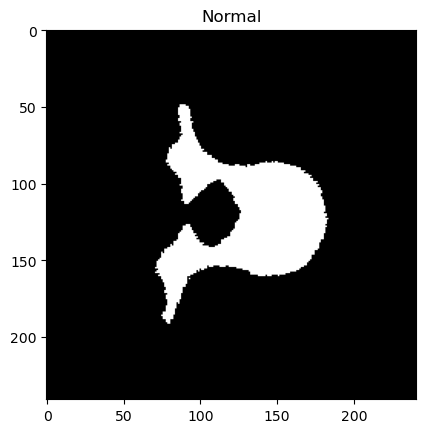

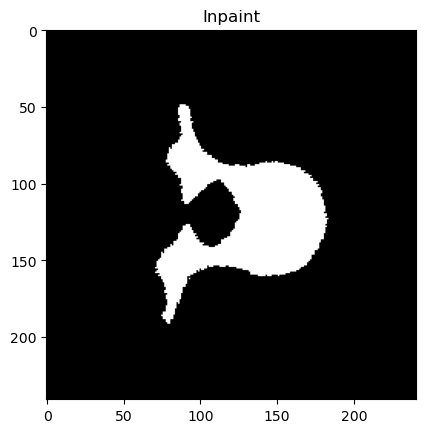

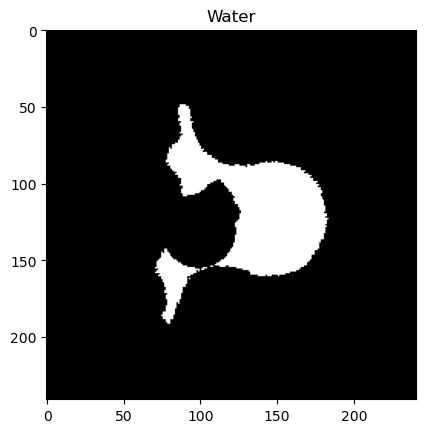

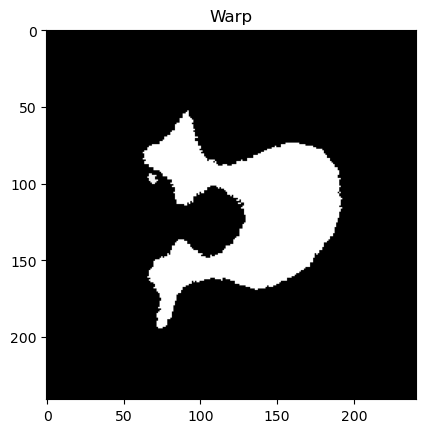

In [14]:
mask_inpaint = load_data(data_path / 'train/crops/sample_0575_crop_label_sphere_outlier_mean_std_inpaint.nii.gz')
mask_normal = load_data(data_path / 'train/crops/sample_0575_crop_label.nii.gz')
mask_water = load_data(data_path / 'train/crops/sample_0575_crop_label_sphere_outlier_water.nii.gz')
mask_warp = load_data(data_path / 'train/crops/sample_0575_crop_label_warp_outlier.nii.gz')

display_image(mask_normal, title='Normal')
display_image(mask_inpaint, title='Inpaint')
display_image(mask_water, title='Water')
display_image(mask_warp, title='Warp')

In [16]:
data_path = Path("/media/7tb_encrypted/od_chall/dataset/challenge_data")
sample_id = "0575"
img_path = data_path / 'train/crops' / f"sample_{sample_id}_crop.nii.gz"
label_path = data_path / 'train/crops' / f"sample_{sample_id}_crop_label.nii.gz"
assert img_path.exists() and label_path.exists()
label = load_data(label_path)
img_itk = load_sitk_data(img_path)
mask_itk = load_sitk_data(label_path)

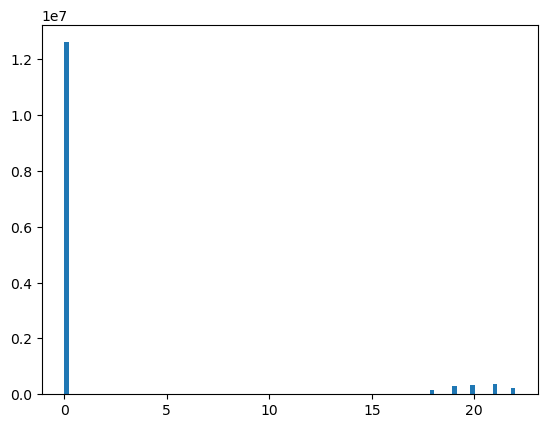

In [17]:
plt.hist(label.flatten(), bins=100)
plt.show()

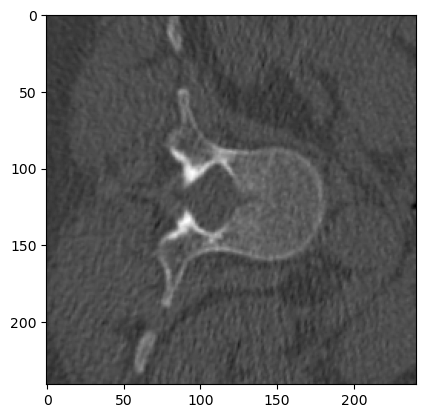

In [12]:
display_image(img)

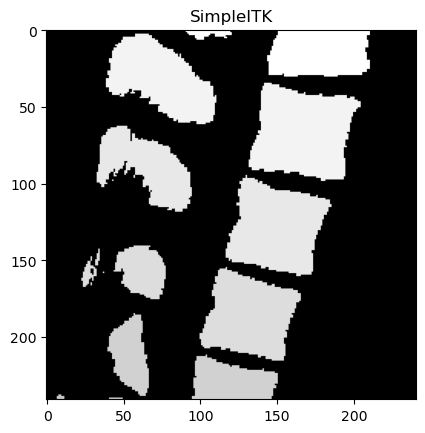

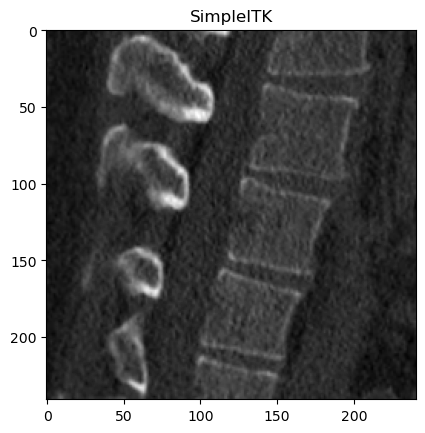

In [22]:
display_image(sitk.GetArrayFromImage(mask_itk), title='SimpleITK')
display_image(sitk.GetArrayFromImage(img_itk), title='SimpleITK')

In [4]:
imageName, maskName = radiomics.getTestCase('brain1')
print(imageName, maskName)

/tmp/pyradiomics/data/brain1_image.nrrd /tmp/pyradiomics/data/brain1_label.nrrd


In [9]:
import os
# Instantiate the extractor
params = this_path / 'Params.yaml'

imagepath_1, labelpath_1 = getTestCase('brain1')
imagepath_2, labelpath_2 = getTestCase('brain2')

image_1 = sitk.ReadImage(imagepath_1)
label_1 = sitk.ReadImage(labelpath_1)
image_2 = sitk.ReadImage(imagepath_2)
label_2 = sitk.ReadImage(labelpath_2)

extractor = featureextractor.RadiomicsFeatureExtractor(str(params))
result_1 = extractor.execute(image_1, label_1)
result_2 = extractor.execute(image_2, label_2)

In [18]:
img = sitk.ReadImage(img_path)
mask = sitk.ReadImage(label_path)

extractor = featureextractor.RadiomicsFeatureExtractor(str(params))
result = extractor.execute(img, mask)

In [25]:
result

OrderedDict([('diagnostics_Versions_PyRadiomics', 'v3.0.1'),
             ('diagnostics_Versions_Numpy', '1.26.4'),
             ('diagnostics_Versions_SimpleITK', '2.3.1'),
             ('diagnostics_Versions_PyWavelet', '1.5.0'),
             ('diagnostics_Versions_Python', '3.10.14'),
             ('diagnostics_Configuration_Settings',
              {'minimumROIDimensions': 2,
               'minimumROISize': None,
               'normalize': False,
               'normalizeScale': 1,
               'removeOutliers': None,
               'resampledPixelSpacing': None,
               'interpolator': 'sitkBSpline',
               'preCrop': False,
               'padDistance': 5,
               'distances': [1],
               'force2D': False,
               'force2Ddimension': 0,
               'resegmentRange': None,
               'label': 20,
               'additionalInfo': True,
               'binWidth': 25,
               'weightingNorm': None}),
             ('diagnostics_Co

In [27]:
import six
# Make an array of the values
features = {}

for key, value in six.iteritems(result_1):
    if key.startswith(('original_shape', 'original_firstorder', 'original_glcm')):
        features[key] = value
        # feature_1 = np.append ( feature_1, result_1[key])
        # feature_2 = np.append ( feature_2, result_2[key])
pd.DataFrame(features, index=[0])

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,original_glcm_Imc1,original_glcm_Imc2,original_glcm_Idm,original_glcm_Idmn,original_glcm_Id,original_glcm_Idn,original_glcm_InverseVariance,original_glcm_MaximumProbability,original_glcm_SumEntropy,original_glcm_SumSquares
0,0.562117,0.46106,28.584423,61.99722,49.490855,65.88906,53.593978,69.60099,16147.5118,34.849702,...,-0.094389,0.694225,0.200223,0.961402,0.287226,0.872605,0.198819,0.007352,5.354241,39.05588


In [24]:
pd.DataFrame(result, columns=result.keys())
# result.keys()

ValueError: All arrays must be of the same length

In [19]:
glcm = radiomics.glcm.RadiomicsGLCM(img_itk, mask_itk)

ValueError: min() arg is an empty sequence

### Scikitimage GLCM

In [6]:
data_path = Path("/media/7tb_encrypted/od_chall/dataset/challenge_data")
sample_id = "0575"
img_path = data_path / 'train/crops' / f"sample_{sample_id}_crop.nii.gz"
label_path = data_path / 'train/crops' / f"sample_{sample_id}_crop_label.nii.gz"
assert img_path.exists() and label_path.exists()
# img = load_data(img_path)
img = load_sitk_data(img_path, True)
mask = load_sitk_data(label_path, True)

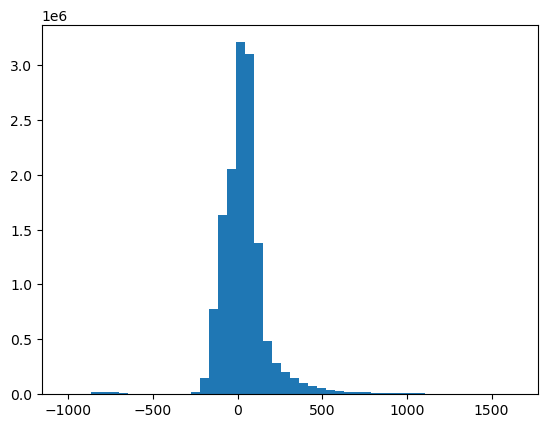

In [8]:
plt.hist(img.flatten(), bins=50)
plt.show()

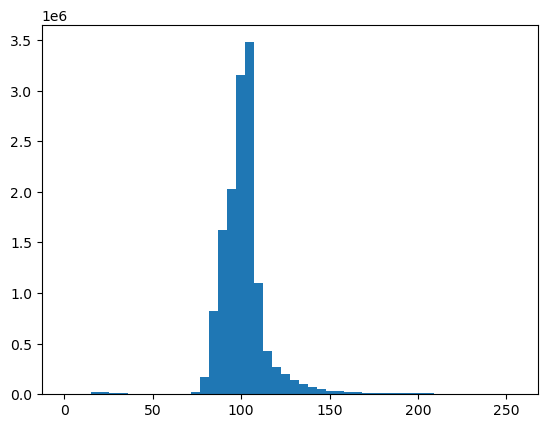

In [9]:
def min_max_norm(img: np.ndarray, max_val: int = None):
    """
    Scales images to be in range [0, 2**bits]

    Args:
        img (np.ndarray): Image to be scaled.
        max_val (int, optional): Value to scale images
            to after normalization. Defaults to None.

    Returns:
        np.ndarray: Scaled image with values from [0, max_val]
    """
    if max_val is None:
        max_val = np.iinfo(img.dtype).max
    img = (img - img.min()) / (img.max() - img.min()) * max_val
    return img

img = min_max_norm(img, max_val=255).astype(np.uint8)
plt.hist(img.flatten(), bins=50)
plt.show()

In [11]:
from skimage.feature import graycomatrix, graycoprops

all_glcm_decomp = graycomatrix(img, [1], [0, np.pi/4, np.pi/2], normed=True)
all_glcm_decomp.shape

ValueError: The parameter `image` must be a 2-dimensional array